### Imports

In [34]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%autoreload 2

In [36]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [37]:
connection = Connection()
# Get client
client = connection.get_client()

In [38]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [39]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [40]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
[Non-physical filter] Rows before: 100, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 98
W06 Record count after preprocessing: 98
W08 original record count: 69
[Non-physical filter] Rows before: 66, dropped: 10 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 56
W08 Record count after preprocessing: 56
W10 original record count: 222
[Non-physical filter] Rows before: 221, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 219
W10 Record count after preprocessing: 219
W11 original record count: 154
[Non-physical filter] Rows before: 119, dropped: 0 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 119
W11 Record coun

723

In [41]:
df_all_wells_preprocessed["pres_drop"].describe()

count    723.000000
mean     104.623834
std        8.451487
min       66.960966
25%      100.268370
50%      103.942967
75%      109.984311
max      183.323377
Name: pres_drop, dtype: float64

In [42]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          28
qg_mpfm          28
qw_mpfm          28
wc_mpfm           0
gor_mpfm         30
wgr_mpfm         31
gor_well_test     0
wgr_well_test     0
pres_drop         0
temp_drop         0
well_id           0
time_idx          0
dtype: int64

In [43]:
df_all_wells_preprocessed[df_all_wells_preprocessed["qw_well_test"] == 0]["qw_well_test"].describe()

count    33.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: qw_well_test, dtype: float64

In [44]:
# df_train, df_val, df_test = get_temporal_split_per_well(df=df_all_wells_preprocessed, val_frac=0.1, test_frac=0.2)
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=510, Validation=74, Test=139


In [45]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [46]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [47]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
assert_model(model)

[INFO] Regime below_normal: 66 samples
[INFO] Regime normal: 335 samples
[INFO] Regime above_normal: 83 samples
[INFO] Validation ML usage fraction: 1.00


In [48]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.8216827413263169,
   'mae': 14.600127441693768,
   'rmse': 17.40087298665198,
   'mape (%)': 19.184165491985627,
   'mpe (%)': 11.80030067360878},
  'qw': {'r2': -0.051819476041704116,
   'mae': 0.9047947668994961,
   'rmse': 1.024380661936223,
   'mape (%)': 511.5774611069098,
   'mpe (%)': 477.7745826093395},
  'qg': {'r2': 0.6964912383507975,
   'mae': 2411.093209174852,
   'rmse': 2861.9838953126873,
   'mape (%)': 20.576830837431224,
   'mpe (%)': -10.839596875876417},
  'wgr': {'r2': -1.2918088385508284,
   'mae': 0.00011054977135986836,
   'rmse': 0.00014309319160160698,
   'mape (%)': 473.3542835249338,
   'mpe (%)': 439.741876959773},
  'gor': {'r2': -294.57661978661474,
   'mae': 35.30948153791792,
   'rmse': 41.549555736177915,
   'mape (%)': 28.332919778786582,
   'mpe (%)': -15.460957815224335}},
 'W08': {'qo': {'r2': -0.6353122568652119,
   'mae': 8.241296382708605,
   'rmse': 11.0735854924896,
   'mape (%)': 99.9943918212155,
   'mpe (%)': 90.2718

In [51]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9705793206097383,
   'mae': 5.251244334730011,
   'rmse': 7.068067627389535,
   'mape (%)': 5.087505632907326,
   'mpe (%)': 0.9097850247602216},
  'qw': {'r2': -1.4355373695504081,
   'mae': 1.1967350710197522,
   'rmse': 1.5587919920143922,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8415131255971016,
   'mae': 1645.6842654738027,
   'rmse': 2068.131833584023,
   'mape (%)': 16.01423859716139,
   'mpe (%)': -4.040459866829176},
  'wgr': {'r2': -1.4794428550210168,
   'mae': 0.00011496850203732674,
   'rmse': 0.0001488356015598762,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -124.20088225410174,
   'mae': 20.839359841032618,
   'rmse': 27.041765352443367,
   'mape (%)': 16.68677657382075,
   'mpe (%)': -4.617117495847496}},
 'W08': {'qo': {'r2': -0.50802701677585,
   'mae': 6.290050234223818,
   'rmse': 10.633897701411447,
   'mape (%)': 99.03654144078287,
   'mpe (%)': 88.01558118858199},
  'qw': {'r2': -23.221162840742952,
 

In [52]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9768491128480871,
   'mae': 4.268030919398496,
   'rmse': 6.269864662681778,
   'mape (%)': 3.5492132046446225,
   'mpe (%)': 3.446269733143492},
  'qw': {'r2': -0.7273317447261942,
   'mae': 1.0025406901276788,
   'rmse': 1.3127397758602168,
   'mape (%)': 89.01677415560223,
   'mpe (%)': -89.01677415560223},
  'qg': {'r2': 0.9854376848906158,
   'mae': 411.95814890003504,
   'rmse': 626.8978514943486,
   'mape (%)': 3.247322892501862,
   'mpe (%)': 3.247322892501862},
  'wgr': {'r2': -0.6656210137554459,
   'mae': 9.597009758287279e-05,
   'rmse': 0.00012198821348498158,
   'mape (%)': 87.72601842003803,
   'mpe (%)': -87.72601842003803},
  'gor': {'r2': -3.5236132551741175,
   'mae': 3.0998481209062643,
   'rmse': 5.140129720837674,
   'mape (%)': 2.4648679725756106,
   'mpe (%)': -0.11832192711184208}},
 'W08': {'qo': {'r2': -0.007214501869849954,
   'mae': 5.408608796977801,
   'rmse': 8.690582807430026,
   'mape (%)': 89.13637879900259,
   'mpe (%)': 77.37

In [53]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

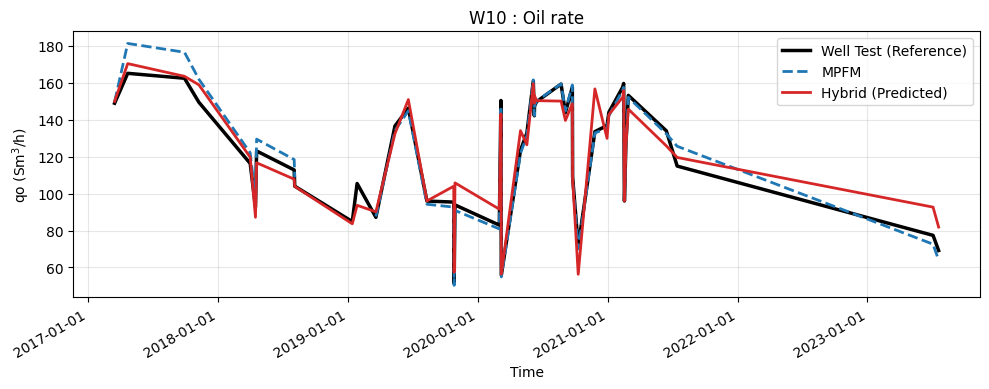

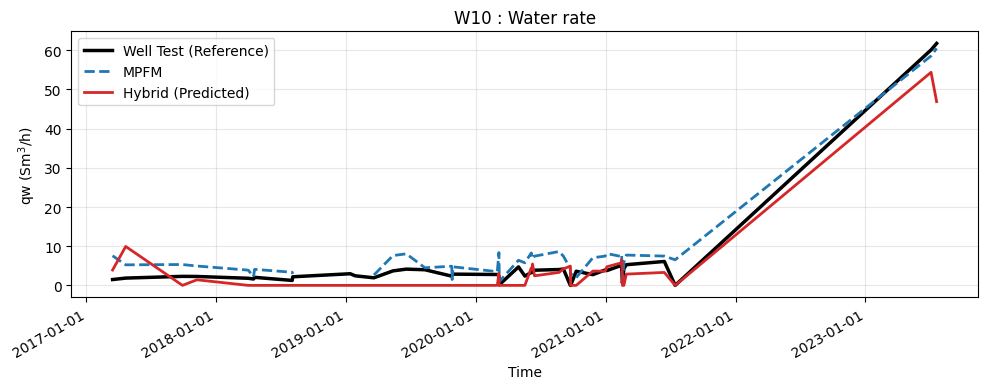

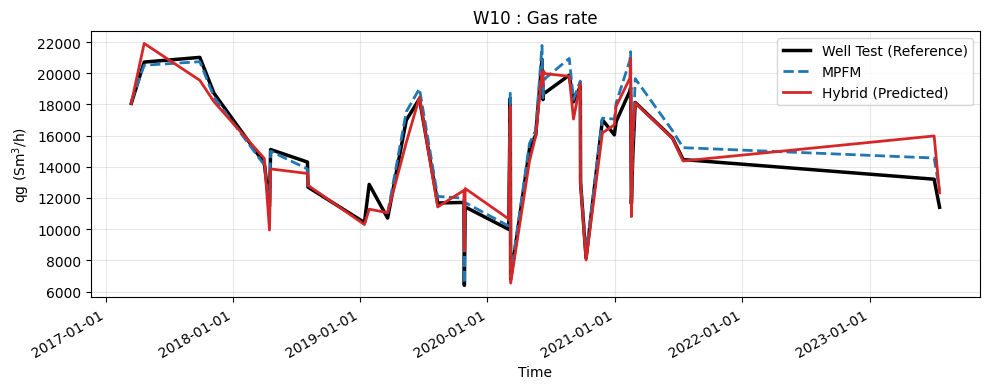

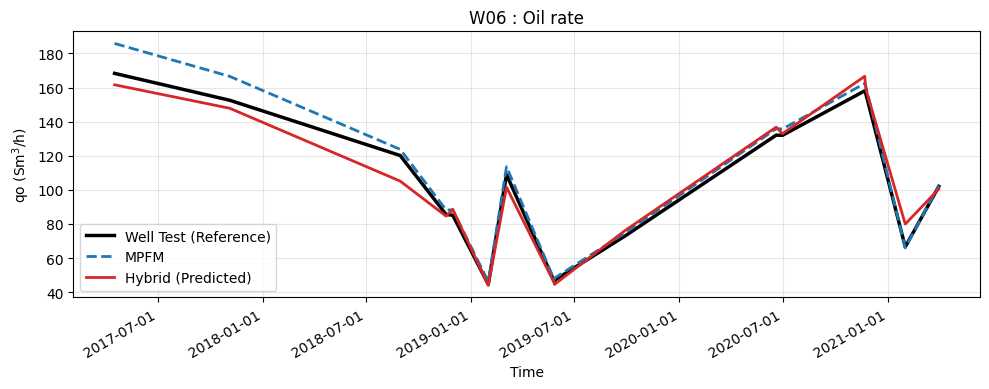

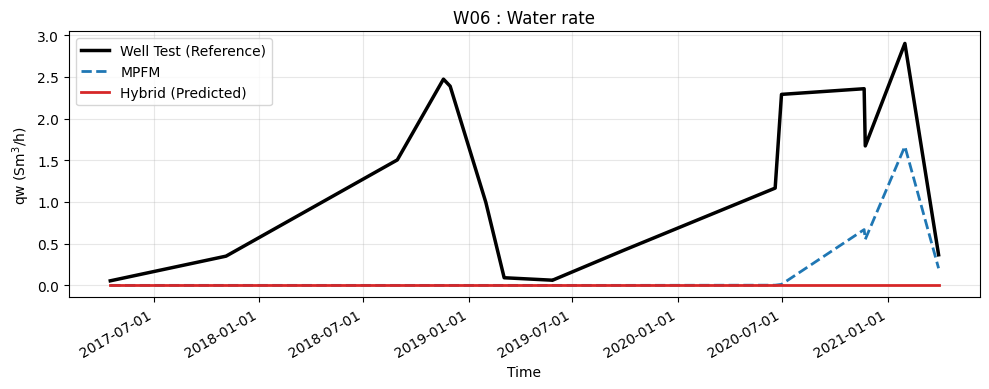

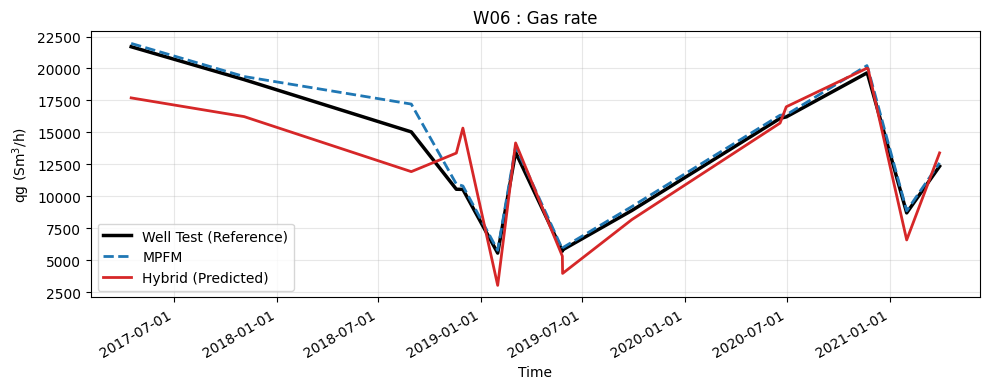

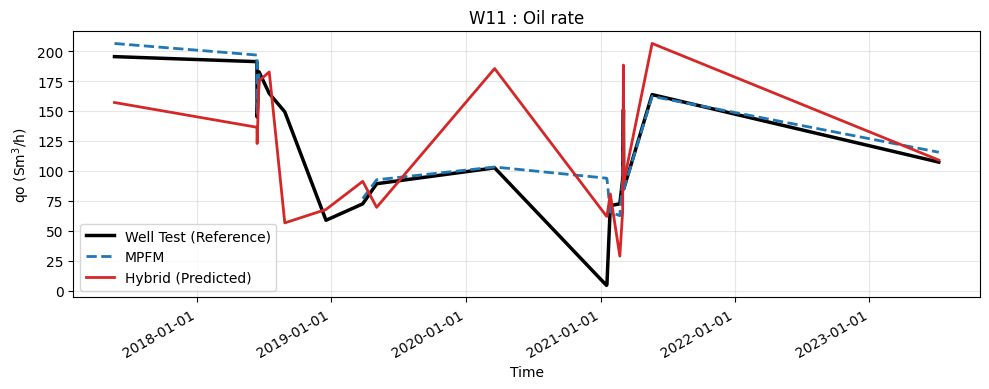

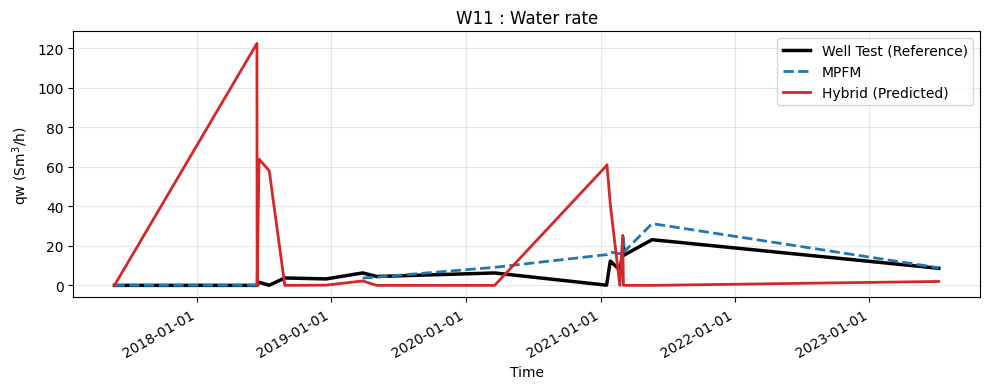

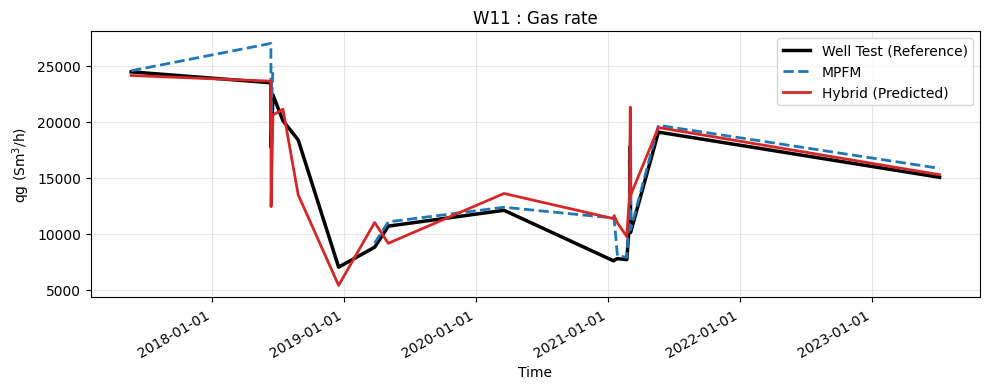

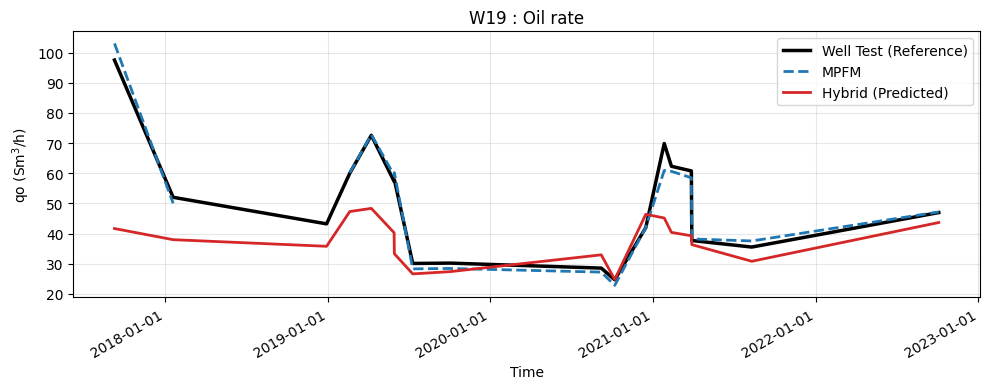

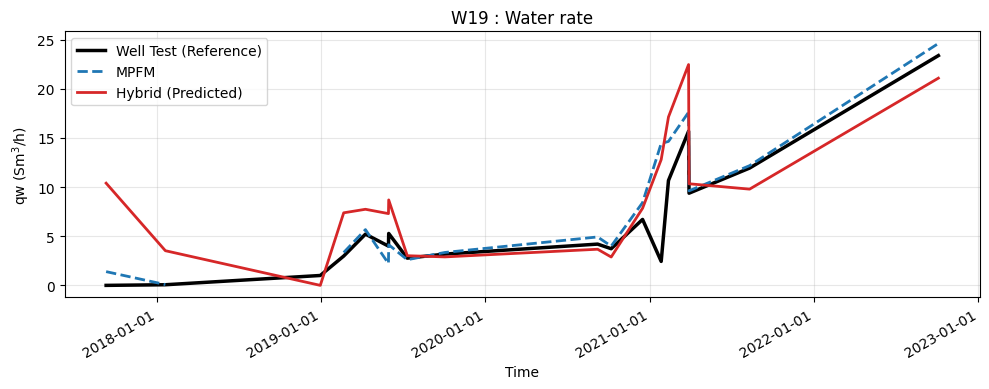

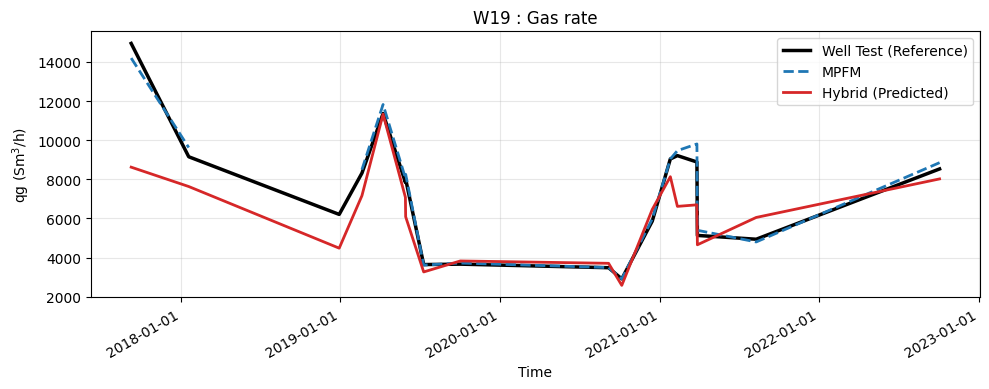

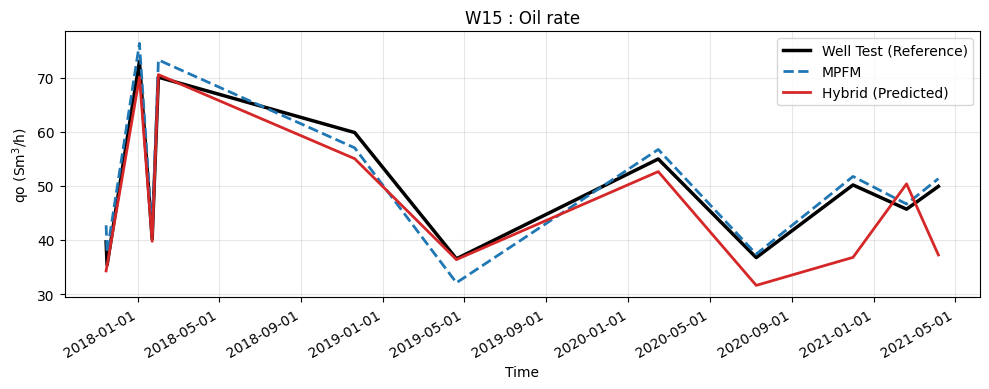

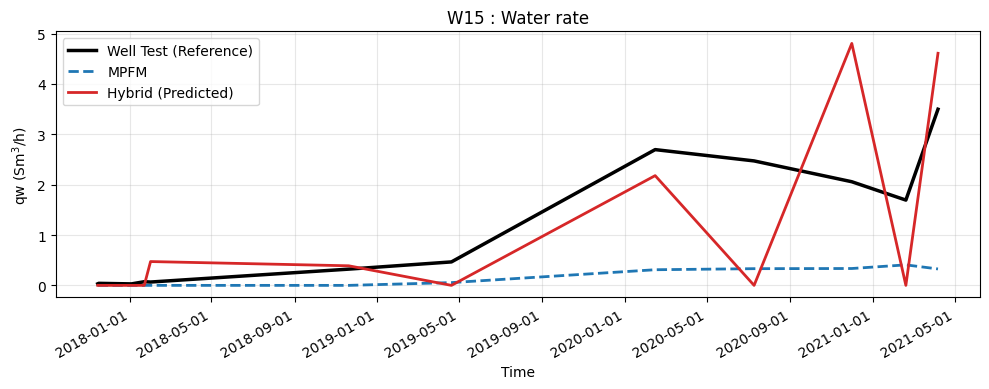

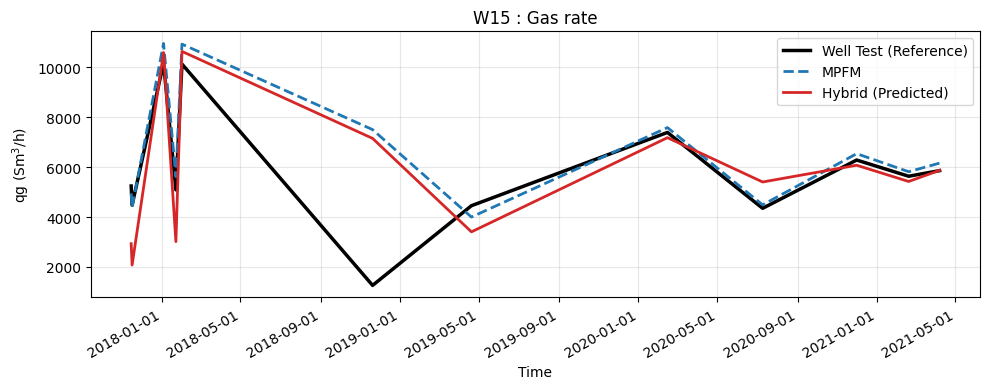

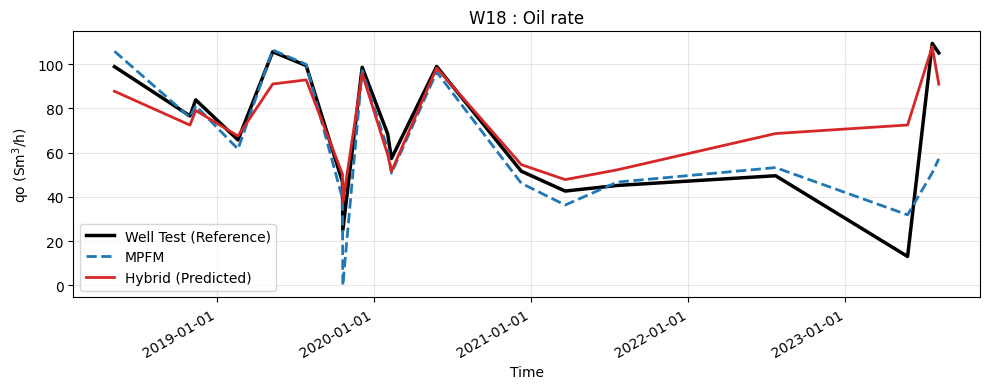

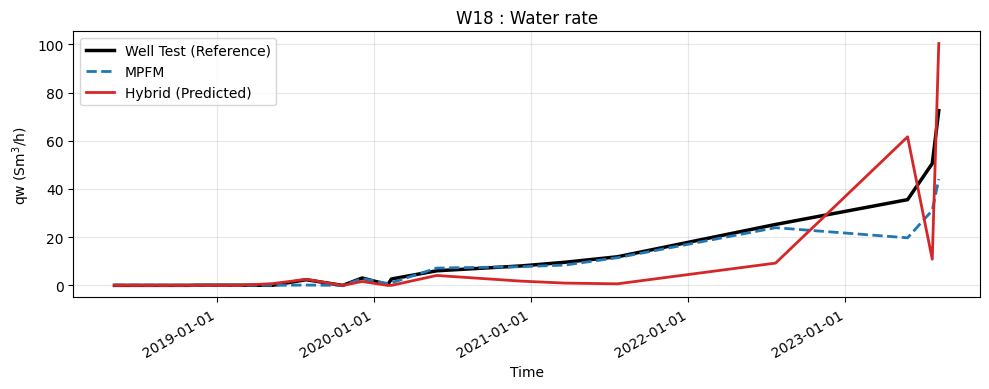

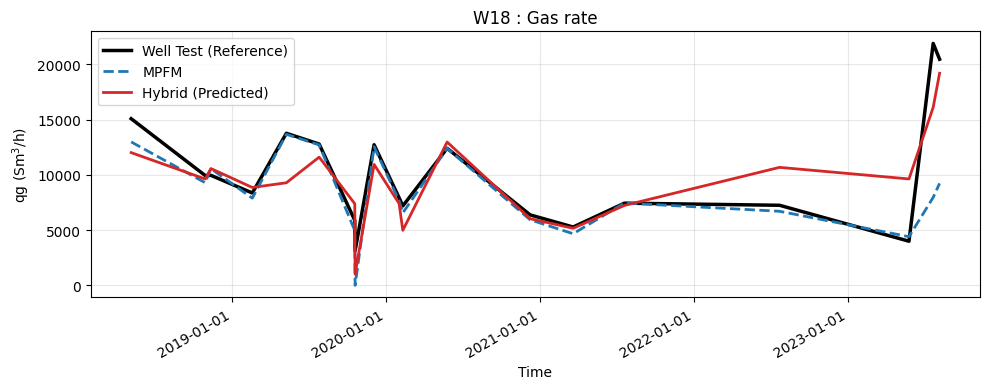

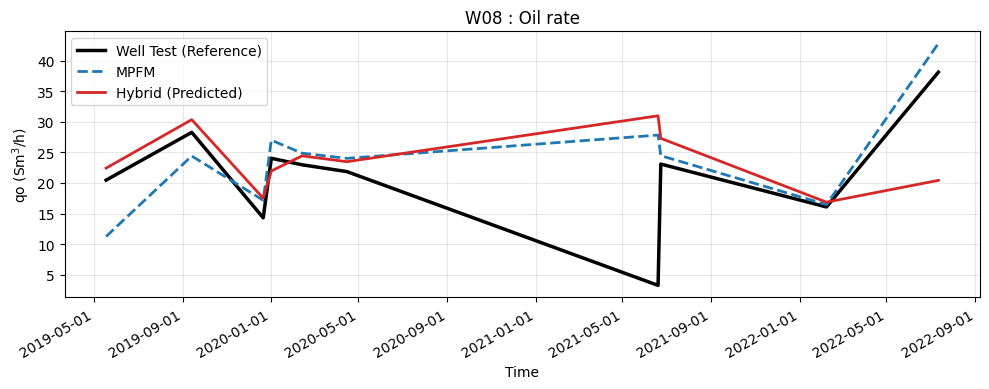

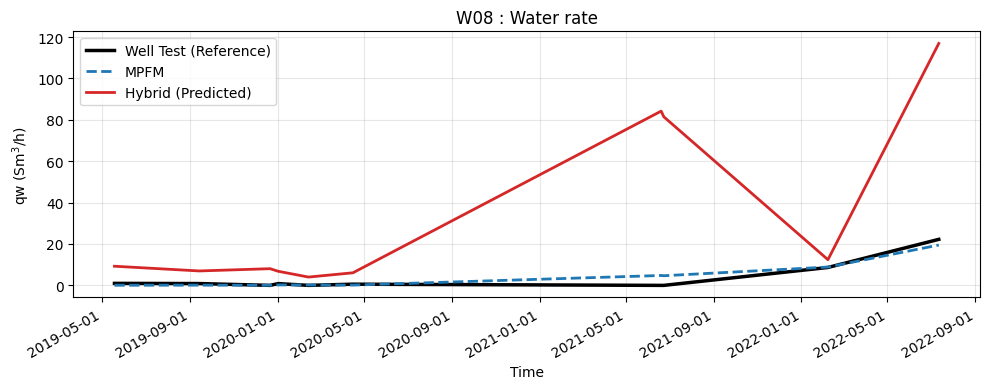

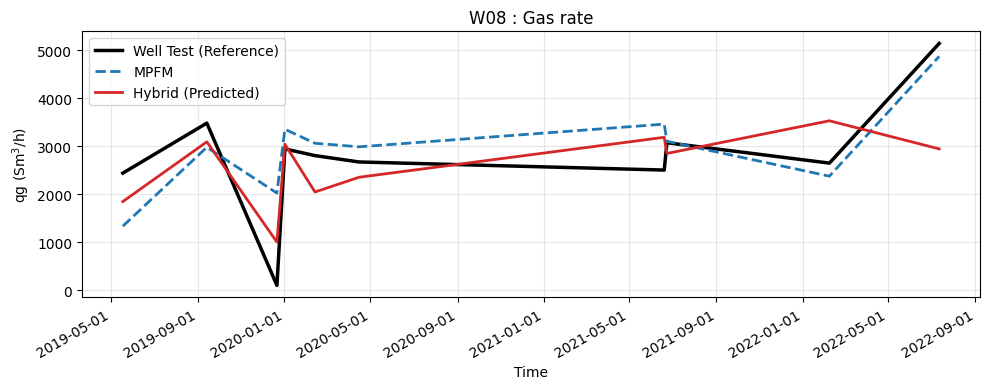

In [54]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [55]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10", is_random_ordered=False)
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=406, Val=98, Calibration=22, Test=197


In [56]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[INFO] Regime below_normal: 55 samples
[INFO] Regime normal: 234 samples
[INFO] Regime above_normal: 84 samples
[INFO] Validation ML usage fraction: 1.00


In [57]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)
assert_model(model_lowo)

In [58]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.13041645623440512,
   'mae': 16.94935955649351,
   'rmse': 28.598065264830737,
   'mape (%)': 18.727038520015576,
   'mpe (%)': 10.677487256479088},
  'qw': {'r2': -0.030704209467977472,
   'mae': 4.147361502533796,
   'rmse': 11.027906230629773,
   'mape (%)': 19878.933807942216,
   'mpe (%)': 19759.753497467736},
  'qg': {'r2': 0.3051091081469589,
   'mae': 2455.9319266000075,
   'rmse': 3070.6964383997747,
   'mape (%)': 19.090366359365593,
   'mpe (%)': -4.99925366577531},
  'wgr': {'r2': -0.25999477527145487,
   'mae': 0.00037745419221407484,
   'rmse': 0.0010647236543190734,
   'mape (%)': 89.95045524383856,
   'mpe (%)': -20.981100410790525},
  'gor': {'r2': -10.15441820916281,
   'mae': 23.44836885942191,
   'rmse': 34.15667909858799,
   'mape (%)': 18.559648418456657,
   'mpe (%)': -9.530245104332643}},
 'GLOBAL': {'qo': {'r2': 0.13041645623440512,
   'mae': 16.94935955649351,
   'rmse': 28.598065264830737,
   'mape (%)': 18.727038520015576,
   'mpe (%)

In [59]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.5733226740494605,
   'mae': 13.589650978584359,
   'rmse': 20.032298318653318,
   'mape (%)': 13.476235566109837,
   'mpe (%)': -5.564167331951474},
  'qw': {'r2': -0.15019799626617547,
   'mae': 5.1834073219247205,
   'rmse': 11.649635661390281,
   'mape (%)': 98.07196039893581,
   'mpe (%)': -98.07196039893581},
  'qg': {'r2': 0.000758612850823237,
   'mae': 2866.759387674901,
   'rmse': 3682.2543375173364,
   'mape (%)': 21.107758540841086,
   'mpe (%)': 10.06529978947145},
  'wgr': {'r2': -0.10119375175528189,
   'mae': 0.0004045804710590756,
   'rmse': 0.0009953696621457255,
   'mape (%)': 97.57464761619596,
   'mpe (%)': -97.14638359021848},
  'gor': {'r2': -26.635957335094048,
   'mae': 38.831687254809964,
   'rmse': 53.76373535412397,
   'mape (%)': 31.261422711334706,
   'mpe (%)': 20.116415731282455}},
 'GLOBAL': {'qo': {'r2': 0.5733226740494605,
   'mae': 13.589650978584359,
   'rmse': 20.032298318653318,
   'mape (%)': 13.476235566109837,
   'mpe (%)

In [60]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9681163185591275,
   'mae': 3.107007080147041,
   'rmse': 5.510968820395964,
   'mape (%)': 2.8301709703624343,
   'mpe (%)': 0.32812133315715225},
  'qw': {'r2': 0.9321283191264426,
   'mae': 2.4157757420605037,
   'rmse': 2.857075021554948,
   'mape (%)': 89823.79975790395,
   'mpe (%)': 89811.21796902441},
  'qg': {'r2': 0.9478188022580767,
   'mae': 487.60241163621396,
   'rmse': 846.4565403990914,
   'mape (%)': 3.3693233250789816,
   'mpe (%)': 2.665470032299862},
  'wgr': {'r2': 0.9495122759691671,
   'mae': 0.00016977035662005816,
   'rmse': 0.00021528302946900916,
   'mape (%)': 82.56853066454097,
   'mpe (%)': 68.6541816615454},
  'gor': {'r2': 0.28279938278934724,
   'mae': 6.35267477615132,
   'rmse': 8.74768113656352,
   'mape (%)': 4.957302679747986,
   'mpe (%)': 2.4901489898369427}},
 'GLOBAL': {'qo': {'r2': 0.9681163185591275,
   'mae': 3.107007080147041,
   'rmse': 5.510968820395964,
   'mape (%)': 2.8301709703624343,
   'mpe (%)': 0.3281213331

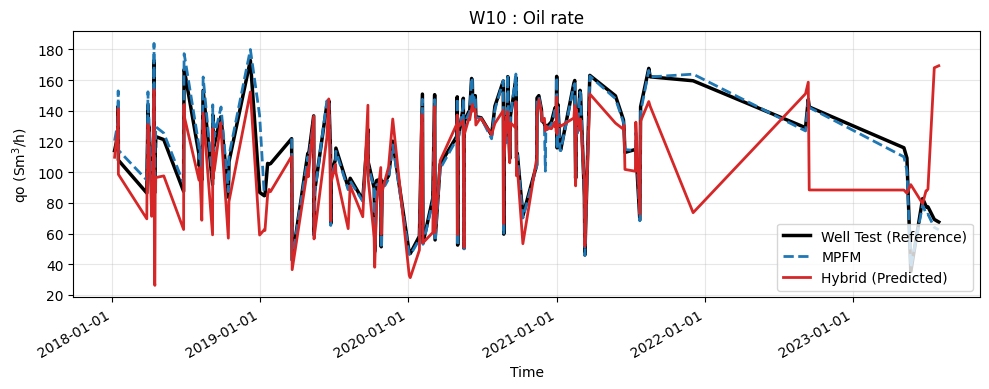

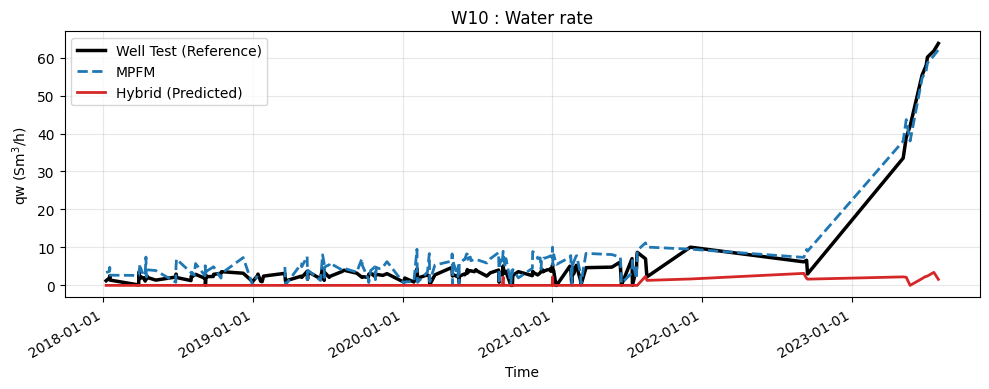

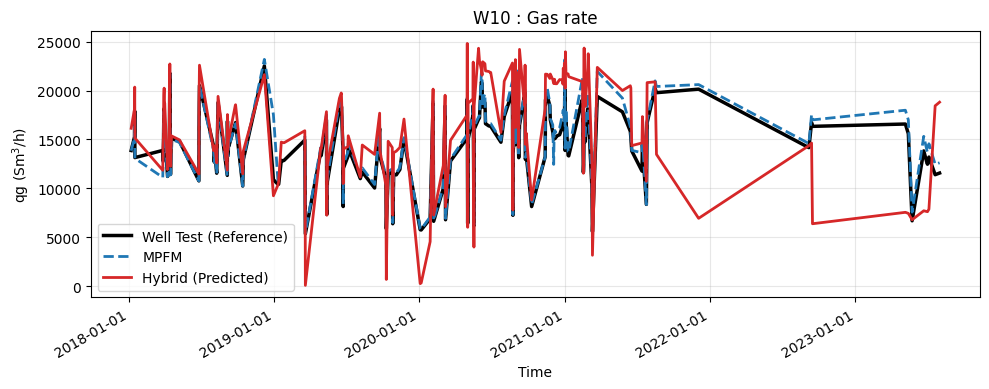

In [61]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [62]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [63]:
# df_resampled.index

In [64]:
# df_resampled.columns

In [65]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [66]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [67]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [68]:
# summarize_null(df_generated)